In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import torch
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import accuracy_score
from rouge import Rouge

import json
import os

from tqdm import tqdm


In [2]:
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.wsd import lesk
for ss in wn.synsets('bank'):
    print(ss, ss.definition())

Synset('bank.n.01') sloping land (especially the slope beside a body of water)
Synset('depository_financial_institution.n.01') a financial institution that accepts deposits and channels the money into lending activities
Synset('bank.n.03') a long ridge or pile
Synset('bank.n.04') an arrangement of similar objects in a row or in tiers
Synset('bank.n.05') a supply or stock held in reserve for future use (especially in emergencies)
Synset('bank.n.06') the funds held by a gambling house or the dealer in some gambling games
Synset('bank.n.07') a slope in the turn of a road or track; the outside is higher than the inside in order to reduce the effects of centrifugal force
Synset('savings_bank.n.02') a container (usually with a slot in the top) for keeping money at home
Synset('bank.n.09') a building in which the business of banking transacted
Synset('bank.n.10') a flight maneuver; aircraft tips laterally about its longitudinal axis (especially in turning)
Synset('bank.v.01') tip laterally
Sy

In [3]:
PATH = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/semeval-2023-task-1-V-WSD-train-v1/trial_v1/"
data = pd.read_csv(PATH+'trial.data.v1.txt', delimiter='\t', header=None)
keys = pd.read_csv(PATH+'trial.gold.v1.txt', delimiter='\t', header=None)
df = pd.concat([data, keys],axis=1)
df.columns = ['keyword', 'context', 'img1', 'img2', 'img3', 'img4', 'img5', 'img6', 'img7', 'img8', 'img9', 'img10', 'gold_key']
df.head()


,keyword,context,img1,img2,img3,img4,img5,img6,img7,img8,img9,img10,gold_key
0,andromeda,andromeda tree,image.155.jpg,image.68.jpg,image.9.jpg,image.72.jpg,image.158.jpg,image.86.jpg,image.7.jpg,image.132.jpg,image.36.jpg,image.27.jpg,image.86.jpg
1,angora,angora city,image.5.jpg,image.52.jpg,image.96.jpg,image.70.jpg,image.46.jpg,image.91.jpg,image.76.jpg,image.139.jpg,image.14.jpg,image.115.jpg,image.70.jpg
2,anteater,marsupial anteater,image.147.jpg,image.16.jpg,image.107.jpg,image.135.jpg,image.93.jpg,image.59.jpg,image.88.png,image.131.jpg,image.89.jpg,image.121.jpg,image.107.jpg
3,bank,bank erosion,image.104.jpg,image.64.jpg,image.108.jpg,image.80.jpg,image.21.jpg,image.99.jpg,image.117.jpg,image.146.jpg,image.87.jpg,image.34.jpg,image.64.jpg
4,router,internet router,image.127.jpg,image.0.jpg,image.20.jpg,image.18.jpg,image.112.jpg,image.97.jpg,image.24.jpg,image.1.jpg,image.56.jpg,image.26.jpg,image.18.jpg


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

In [20]:
generated_text_dict = {}

In [27]:
for row in tqdm(range(len(df))):
    for img in range(1,11):
        selected_col = df.iloc[row][f'img{img}']
        
        if selected_col in generated_text_dict.keys():
            pred = generated_text_dict[selected_col]
            
        
        else:
            IMAGE_PATH = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/semeval-2023-task-1-V-WSD-train-v1/trial_v1/trial_images_v1/"
            IMAGE_PATH_EACH = IMAGE_PATH + selected_col
            
            plot_img = Image.open(IMAGE_PATH_EACH)
            if plot_img.mode != "RGB":          #add this thing
                plot_img = plot_img.convert(mode="RGB")
                
                
            pixel_values = feature_extractor(images= plot_img, return_tensors="pt").pixel_values
            pixel_values = pixel_values.to(device)  
            gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
            output_ids = model.generate(pixel_values, **gen_kwargs)
            pred = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
            
            generated_text_dict[selected_col] = pred[0]
            
        

100%|██████████| 16/16 [02:09<00:00,  8.08s/it]


## Writing json file

In [28]:
filename = 'test-image-description.json'
with open(filename, 'w') as f:
    json.dump(generated_text_dict, f, sort_keys=True, indent=4)

## Reading photos and transform to text from Arysse

In [33]:
arysse_generated_text= {}

In [34]:

for row in tqdm(range(len(df))):

    IMAGE_PATH = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/V-WSD/poon-method/combined_method/photo_from_arysse/"
    IMAGE_PATH_EACH = IMAGE_PATH + f"image1_{row}.png"
    # print(IMAGE_PATH_EACH)
    
    plot_img = Image.open(IMAGE_PATH_EACH)
    if plot_img.mode != "RGB":          #add this thing
        plot_img = plot_img.convert(mode="RGB")
        
        
    pixel_values = feature_extractor(images= plot_img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)  
    gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
    output_ids = model.generate(pixel_values, **gen_kwargs)
    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    
    arysse_generated_text[f"image1_{row}.png"] = pred[0]

100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


In [35]:
filename = 'arysse-test-image-description.json'
with open(filename, 'w') as f:
    json.dump(arysse_generated_text, f, sort_keys=True, indent=4)

---

# Compute text similarity

In [234]:
similarity_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [227]:
sentences = [
    "I am going crazy",
    "Oops, I did it again",
    "Don't let me be the last to know",
    "You are getting on my last nerves"]

In [228]:
output = similarity_model.encode(sentences)
cosine_similarity(
    [output[0]],
    output[1:]
)

array([[0.13393424, 0.23756652, 0.2533574 ]], dtype=float32)

In [50]:
for i in arysse_generated_text.keys():
    print(arysse_generated_text[i])

a tree that has a bunch of leaves on it 
a large building with a lot of trees 
an animal that is laying down on the ground 
a pile of sand on the beach 
a black and white photo of an electronic device 
a hand holding a small device in front of a wall 
a man holding a baseball bat on top of a tennis court 
a subway train that is stopped at a platform 
a black and white photo of a white object 
a painting of a man riding a horse 
a bowl of eggs on top of a white plate 
a woman on a grassy field with a frisbee 
a young boy dressed in a pirate costume 
a collage of photos of a man in a suit and tie 
a beautiful young woman posing in front of a wall 
a plate of food with vegetables and fruit 


In [115]:
def map_correct_label(dataframe):
    mapped_class = []
    for row in range(len(dataframe)):
        value_list = []
        for num in range(1 ,11):
            col = f"img{num}"
            value_list.append(dataframe[col].iloc[row])
            key_value = dataframe.gold_key.iloc[row]
        output = value_list.index(key_value)
        mapped_class.append(output)

        
    return mapped_class
    

In [120]:
df['mapped_label'] = map_correct_label(df)
df.head()

,keyword,context,img1,img2,img3,img4,img5,img6,img7,img8,img9,img10,gold_key,mapped_label
0,andromeda,andromeda tree,image.155.jpg,image.68.jpg,image.9.jpg,image.72.jpg,image.158.jpg,image.86.jpg,image.7.jpg,image.132.jpg,image.36.jpg,image.27.jpg,image.86.jpg,5
1,angora,angora city,image.5.jpg,image.52.jpg,image.96.jpg,image.70.jpg,image.46.jpg,image.91.jpg,image.76.jpg,image.139.jpg,image.14.jpg,image.115.jpg,image.70.jpg,3
2,anteater,marsupial anteater,image.147.jpg,image.16.jpg,image.107.jpg,image.135.jpg,image.93.jpg,image.59.jpg,image.88.png,image.131.jpg,image.89.jpg,image.121.jpg,image.107.jpg,2
3,bank,bank erosion,image.104.jpg,image.64.jpg,image.108.jpg,image.80.jpg,image.21.jpg,image.99.jpg,image.117.jpg,image.146.jpg,image.87.jpg,image.34.jpg,image.64.jpg,1
4,router,internet router,image.127.jpg,image.0.jpg,image.20.jpg,image.18.jpg,image.112.jpg,image.97.jpg,image.24.jpg,image.1.jpg,image.56.jpg,image.26.jpg,image.18.jpg,3


In [235]:
score_matrix = []
candidate_description_list_all = []
for img_idx, dict_key in enumerate(arysse_generated_text.keys()):
    generated_context_desc = arysse_generated_text[dict_key]
    candidate_description_list= [generated_context_desc]
    for candidate_idx in range(1, 11):
        selected_img= df.iloc[img_idx, candidate_idx+1]
        candidate_desc = generated_text_dict[selected_img]
        candidate_description_list.append(candidate_desc)
        
        
    candidate_description_list_all.append(candidate_description_list) 
    similarity_score = similarity_model.encode(candidate_description_list)
    score = cosine_similarity( [similarity_score[0]], similarity_score[1:]).tolist()[0]
    score_matrix.append(score)


In [327]:
print(np.argmax(np.array(score_matrix), 1) )
print(np.array(df.mapped_label.tolist()))

[7 3 1 4 3 6 9 5 9 5 2 1 1 9 9 9]
[5 3 2 1 3 2 9 5 9 7 2 5 6 9 1 2]


In [237]:
print(np.sum(np.argmax(np.array(score_matrix), 1) ==  np.array(df.mapped_label.tolist())))

7


In [241]:
score_matrix[3]

[0.37541890144348145,
 0.3866680860519409,
 0.32376351952552795,
 0.061906930059194565,
 0.7412092089653015,
 0.3539832830429077,
 0.06877288222312927,
 0.23471423983573914,
 -0.017352674156427383,
 0.21675467491149902]

In [ ]:
ARYSSE_PHOTO_PAHT = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/V-WSD/poon-method/combined_method/photo_from_arysse/"
SELECTED_KEY_PHOTO_PAHT = ARYSSE_PHOTO_PAHT + f"image1_{row}"

Text(0.5, 1.0, 'a plate of food with vegetables and fruit ')

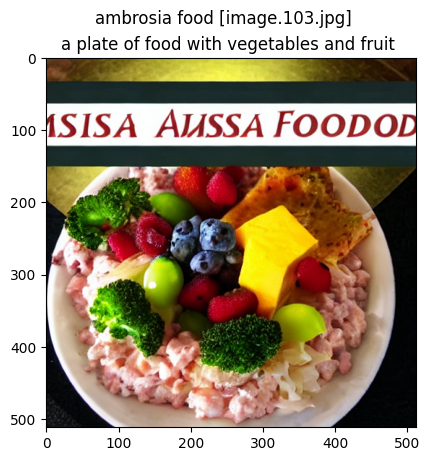

In [338]:
row = 15
ARYSSE_PHOTO_PAHT = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/V-WSD/poon-method/combined_method/photo_from_arysse/"
SELECTED_KEY_PHOTO_PAHT = ARYSSE_PHOTO_PAHT + f"image1_{row}.png"

plot_img = Image.open(SELECTED_KEY_PHOTO_PAHT)
plt.imshow(plot_img)
plt.suptitle(df.iloc[row].context + f" [{df.iloc[row].gold_key}]")
plt.title(arysse_generated_text[f"image1_{row}.png"])



In [359]:
candidate_description_list_all[0]

['a tree that has a bunch of leaves on it ',
 'a flower in a flower pot on a sunny day ',
 'a black and white photo of a plant in a field ',
 'a close up picture of an orange on a surface ',
 'a field with a bunch of yellow flowers in it ',
 'a vase filled with flowers on top of a field ',
 'a flower arrangement in a flower pot in a garden ',
 'a black and white photo of a white surfboard in the water ',
 'a tree with a sky background ',
 'a close up of a close up of a close up of a close up',
 'a plant that is growing out of the ground ']

In [361]:
a = 'a tree that has a bunch of leaves on it'
b_0 = 'a flower arrangement in a flower pot in a garden '
b_1 = 'a tree with a sky background '
b_2 =  'a large green field with a bunch of green plants in it '

In [362]:
rouge_score_0 = rouge.get_scores(b_0, a )[0]['rouge-1']['r']
rouge_score_1 = rouge.get_scores(b_1, a )[0]['rouge-1']['r']
rouge_score_2 = rouge.get_scores(b_2, a )[0]['rouge-1']['r']

print(rouge_score_0, rouge_score_1, rouge_score_2)    

0.1111111111111111 0.2222222222222222 0.4444444444444444


In [348]:
rouge_score

0.5

In [340]:
rouge = Rouge()

In [334]:
score_matrix[3]

[0.37541890144348145,
 0.3866680860519409,
 0.32376351952552795,
 0.061906930059194565,
 0.7412092089653015,
 0.3539832830429077,
 0.06877288222312927,
 0.23471423983573914,
 -0.017352674156427383,
 0.21675467491149902]

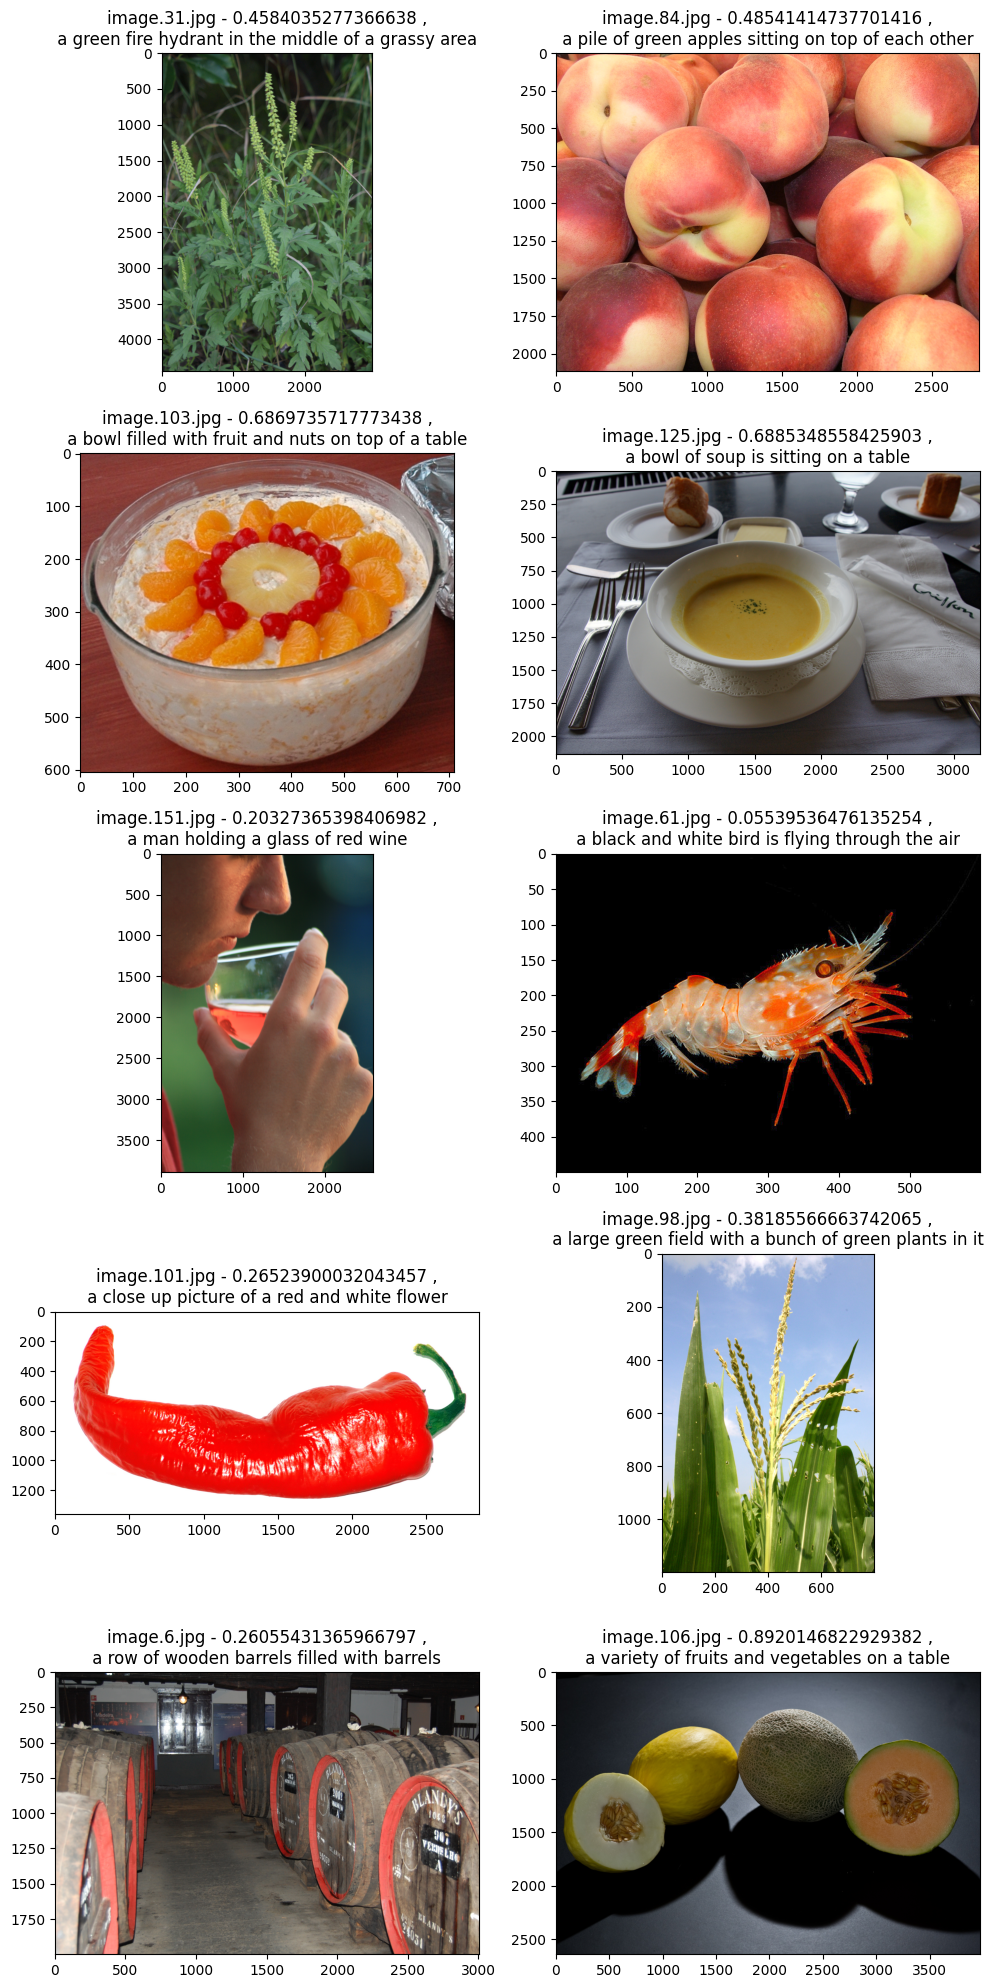

In [339]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (10,20))

for img in range(1,11):
    selected_col = df.iloc[row][f'img{img}']
    IMAGE_PATH = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/semeval-2023-task-1-V-WSD-train-v1/trial_v1/trial_images_v1/"
    IMAGE_PATH_EACH = IMAGE_PATH + selected_col
    
    plot_img = Image.open(IMAGE_PATH_EACH)
    axes.flatten()[img-1].imshow(plot_img)
    axes.flatten()[img-1].set_title(f"{selected_col} - {score_matrix[row][img-1]} ,\n {generated_text_dict[selected_col]}")
    plt.tight_layout()

In [324]:
score_matrix[row]

[0.40342557430267334,
 0.6441419124603271,
 0.4131656885147095,
 0.6506786942481995,
 0.6460137367248535,
 0.5290894508361816,
 0.17445673048496246,
 0.7503365874290466,
 0.42970725893974304,
 0.7024884819984436]

In [313]:
generated_context_desc

'a plate of food with vegetables and fruit '

In [294]:
score_matrix[row]

[0.37541890144348145,
 0.3866680860519409,
 0.32376351952552795,
 0.061906930059194565,
 0.7412092089653015,
 0.3539832830429077,
 0.06877288222312927,
 0.23471423983573914,
 -0.017352674156427383,
 0.21675467491149902]

In [155]:
similarity_score = similarity_model.encode(candidate_description_list)
cosine_similarity( [similarity_score[0]], similarity_score[1:])

array([[0.45840353, 0.48541415, 0.6869736 , 0.68853486, 0.20327365,
        0.05539536, 0.265239  , 0.38185567, 0.2605543 , 0.8920147 ]],
      dtype=float32)

In [158]:
pd.DataFrame([[1 ,2 ,3], [4,5,6]])

,0,1,2
0,1,2,3
1,4,5,6
